In [1]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import glob, copy
from scipy import stats
import photutils
import math
import astroalign as asa
from statistics import mean
from itertools import chain

# Bias

In [2]:
files_bias = glob.glob("./spectroscopy/bias*.fit")

In [162]:
files_bias

['./spectroscopy/bias Image-023.fit',
 './spectroscopy/bias Image-026.fit',
 './spectroscopy/bias Image-027.fit',
 './spectroscopy/bias Image-025.fit',
 './spectroscopy/bias Image-024.fit']

In [168]:
bias0 = fits.open(files_bias[0])

In [172]:
bias0[0].header

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 2750 /                                                
NAXIS2  =                 2200 /                                                
BZERO   =         32768.000000 /                                                
BSCALE  =             1.000000 /                                                
OBJECT  = '' /                                                                  
OBSERVER= '' /                                                                  
ORIGIN  = '' /                                                                  
TELESCOP= '' /                                                                  
FOCALLEN= '' /                                                                  
APTDIA  = '' /              

In [167]:
bb=[]
for i in range(5):
    print(fits.open(files_bias[i])[0].data[1300,200])

1366
1374
1376
1395
1371


In [166]:
mean(bb)

1376

In [5]:
def stacking(files,normalize=False,unbias=False):
    allpic=[]
    npic=0
    for ii, bb in enumerate(files) :
        mypic=fits.open(bb)
        allpic.append(mypic[0].data)
        mypic.close()
        npic+=1
    allpic=np.array(allpic)
    #print('Shape of stack', allpic.shape)
    meanval=np.mean(allpic, axis=0)
    if type(unbias) == np.ndarray:
        meanval = meanval - unbias
    if normalize:
        meanval = meanval/(np.mean(meanval))
    #print("Shape of array", meanval.shape)
    return meanval
    
meanbias = stacking(files_bias)
plt.clf()


<Figure size 640x480 with 0 Axes>

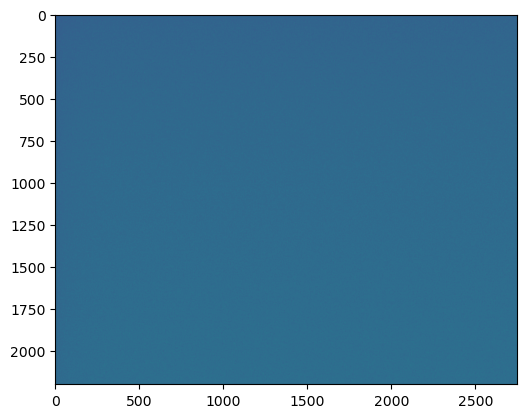

In [6]:
plt.imshow(meanbias,clim=[1320,1470])

# Flat

In [7]:
files_flat = glob.glob("./spectroscopy/flat*.fit")


In [8]:
files_flat

['./spectroscopy/flat Image-016.fit',
 './spectroscopy/flat Image-017.fit',
 './spectroscopy/flat Image-019.fit',
 './spectroscopy/flat Image-018.fit',
 './spectroscopy/flat Image-022.fit',
 './spectroscopy/flat Image-020.fit',
 './spectroscopy/flat Image-021.fit']

In [9]:
mean_flat = stacking(files_flat,unbias=meanbias,normalize=False)

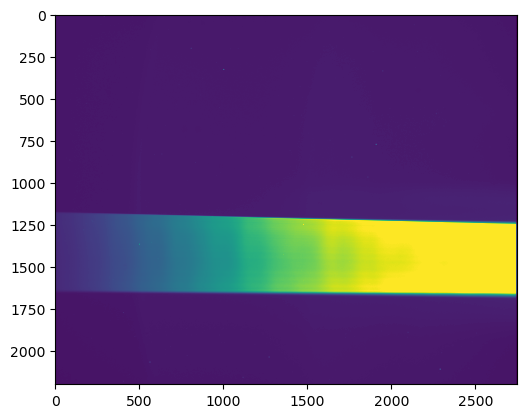

In [10]:
plt.imshow(mean_flat,clim=[0,6000])

# Algoritmic edges detection

In [126]:
#This cell will take the column of pixel at x=95% of total width (as it is a portion bright enough but not extreme, as in the very end of the image there is no data), and compute the y span in which to find upper and lower boundary
sopra=[]
sotto=[]
window_y=6
window_x=10
span=[window_y,mean_flat.shape[0]-window_y]

x_high = int(mean_flat.shape[1]*0.95)
diff = []
for y in range(span[0],span[1]):
        diff.append(np.array(mean_flat[y-window_y:y,x_high-window_x:x_high]).mean()-np.array(mean_flat[y-window_y+1:y+1,x_high-window_x:x_high]).mean())
span=[np.array(diff).argmin(),np.array(diff).argmax()]
span_orig=copy.copy(span)
sopra.extend([(x_high,span[0])]*8)
sotto.extend([(x_high,span[1])]*8)


In [127]:
#from the x at 90% previously found, this cell move to the left in x axis and find the upper and lower boundary, contraining that they has to be in an interval of the median of the previous 8 points to avoid outliers
for x in reversed(range(0,x_high)):
    diff = []
    for y in chain(range(span[0]-30,span[0]+30),range(span[1]-30,span[1]+30)):
        diff.append(np.array(mean_flat[y-window_y:y,x]).mean()-np.array(mean_flat[y-window_y+1:y+1,x]).mean())

    sopra.extend([(x,np.array(diff).argmin()+span[0]-30)])
    sotto.extend([(x,np.array(diff).argmax()+span[0]-30+(span[1]-span[0]-60))])

    span=[int(np.median(np.array(sopra)[-8:-1,1])),int(np.median(np.array(sotto)[-8:-1,1]))]


    

In [128]:
#this cell compute the rest, so the same thing from x=90%width to the end of the image
span=copy.copy(span_orig)
sopra_high=[]
sotto_high=[]
sopra_high.extend([(x_high,span[0])]*8)
sotto_high.extend([(x_high,span[1])]*8)

for x in range(x_high,mean_flat.shape[1]):
    diff = []
    for y in chain(range(span[0]-30,span[0]+30),range(span[1]-30,span[1]+30)):

        diff.append(np.array(mean_flat[y-window_y:y,x]).mean()-np.array(mean_flat[y-window_y+1:y+1,x]).mean())

    sopra_high.extend([(x,np.array(diff).argmin()+span[0]-30)])
    sotto_high.extend([(x,np.array(diff).argmax()+span[0]-30+(span[1]-span[0]-60))])

    span=[int(np.median(np.array(sopra_high)[-8:-1,1])),int(np.median(np.array(sotto_high)[-8:-1,1]))]

sopra.extend(sopra_high)
sotto.extend(sotto_high)
sopra.sort()
sotto.sort()

In [129]:
#this cell corrects the outliers, so if the difference between two consecutive points is too high, it takes the value of the previous point
for i in range(len(sopra)-1):
    if (abs(sopra[i][1]-sopra[i+1][1])>15):
        sopra[i+1]=(sopra[i+1][0],sopra[i][1])
    if (abs(sotto[i][1]-sotto[i+1][1])>15):
        sotto[i+1]=(sotto[i+1][0],sotto[i][1])



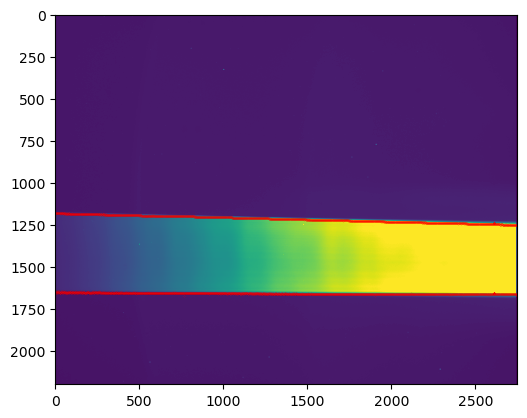

In [130]:
#plot sopra and sotto as scatterplot
plt.imshow(mean_flat,clim=[0,6000])
plt.scatter(*zip(*sopra),s=0.01,c='r')
plt.scatter(*zip(*sotto),s=0.01,c='r')


# Convolutional edges detection

In [50]:
window_y=8
if window_y%2!=0:
    window_y+=1
sopra_conv=[]
sotto_conv=[]
for x in range(0,mean_flat.shape[1]):
    conv = []
    for y in range(window_y,mean_flat.shape[0]):
        conv.append((np.array(mean_flat[y-window_y:y,x])*np.array([-1]*int((window_y/2))+[1]*int((window_y/2)))).mean())
    sopra_conv.extend([(x,np.array(conv).argmax()+window_y)])
    sotto_conv.extend([(x,np.array(conv).argmin()+window_y)])
       
    

In [55]:
#this cell corrects the outliers, so if the difference between two consecutive points is too high, it takes the value of the previous point
for i in range(len(sopra_conv)-1):
    if (abs(sopra_conv[i][1]-sopra_conv[i+1][1])>15):
        sopra_conv[i+1]=(sopra_conv[i+1][0],sopra_conv[i][1])
    if (abs(sotto_conv[i][1]-sotto_conv[i+1][1])>15):
        sotto_conv[i+1]=(sotto_conv[i+1][0],sotto_conv[i][1])



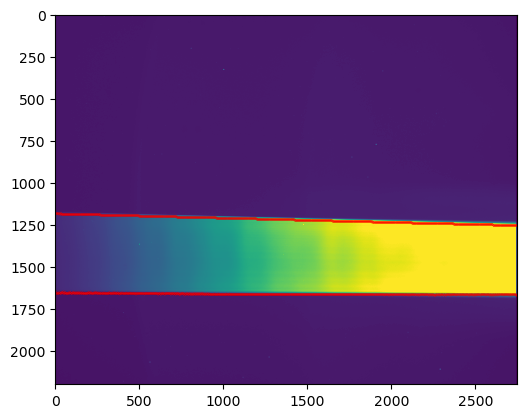

In [56]:
#plot sopra and sotto as scatterplot
plt.imshow(mean_flat,clim=[0,6000])
plt.scatter(*zip(*sopra_conv),s=0.01,c='r')
plt.scatter(*zip(*sotto_conv),s=0.01,c='r')
#save the image


In [118]:

mean_flat_x=[]
std_flat_x=[]
for x in range(mean_flat.shape[1]):
    mean_flat_x.append(np.array(mean_flat[sopra_conv[x][1]:sotto_conv[x][1],x]).mean())
    std_flat_x.append(np.array(mean_flat[sopra_conv[x][1]:sotto_conv[x][1],x]).std())
mean_flat_x=np.array(mean_flat_x)
std_flat_x=np.array(std_flat_x)
flat_grand_mean=np.array(mean_flat_x).mean()
flat_grand_std=np.array(std_flat_x).mean()
grandflat=mean_flat/flat_grand_mean

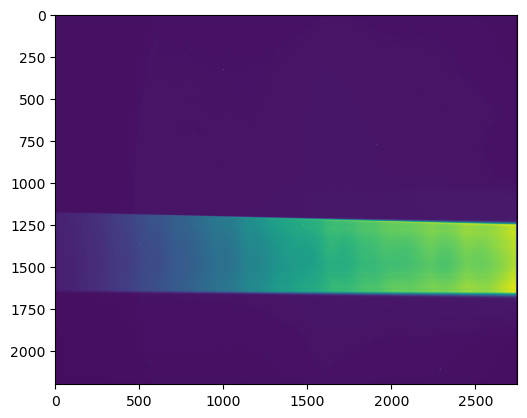

In [119]:
plt.imshow(grandflat,clim=[0,2])

# Science image loading

In [410]:
IMMAG = glob.glob("./spectroscopy/HD3360*.fit")

In [411]:
IMMAG_raw = fits.open(IMMAG[1])[0].data

/var/folders/9h/wspygsdd64nc8w1bt957q7t40000gn/T/ipykernel_14818/3819939026.py:2: RuntimeWarning: divide by zero encountered in divide
  IMMAG_0_flat = IMMAG_0/grandflat


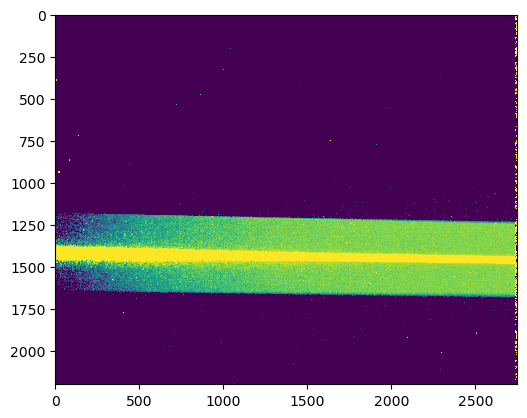

In [412]:
IMMAG_0 = stacking([IMMAG[0]],unbias=meanbias)
IMMAG_0_flat = IMMAG_0/grandflat
#stacked_IMMAG = stacked_IMMAG/mean_flat_norm
#plot the image
plt.imshow(IMMAG_0_flat,clim=[-50,4])

## Subregion selection
(to do on science frame, not on mean_flat, following code just to show the method)

In [413]:
coord=[]
sky=[]
for x in range(IMMAG_0_flat.shape[1]):
    sky_x=[]
    y_span=sotto_conv[x][1]-sopra_conv[x][1]
    for y in chain(range(sopra_conv[x][1]+int(15/100*y_span),sopra_conv[x][1]+int(30/100*y_span)),range(sopra_conv[x][1]+int(70/100*y_span),sopra_conv[x][1]+int(85/100*y_span))):
        coord.append((x,y))
        sky_x.append(IMMAG_0_flat[y,x])
    sky_x=np.array(sky_x)
    sky.append(np.median(sky_x))

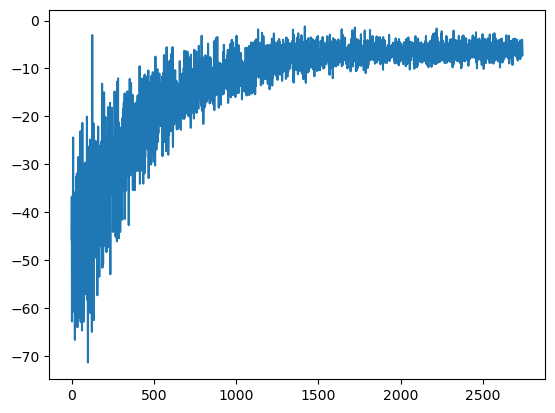

In [414]:
plt.plot(sky[:-9])

In [415]:
sky_repeated=np.tile(np.array(sky),(meanbias.shape[0],1))

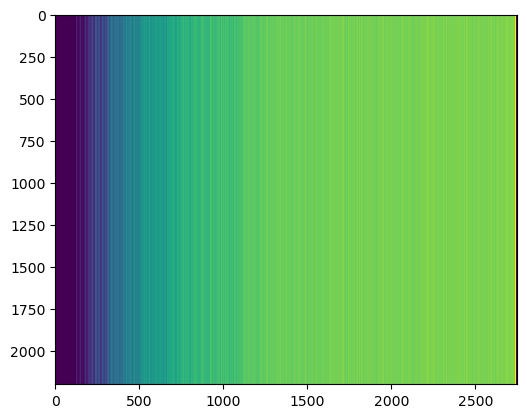

In [416]:
#plot the sky repeated
plt.imshow(sky_repeated,clim=[-40,2])


In [417]:
IMMAG_0_flat_sky=IMMAG_0_flat-sky_repeated

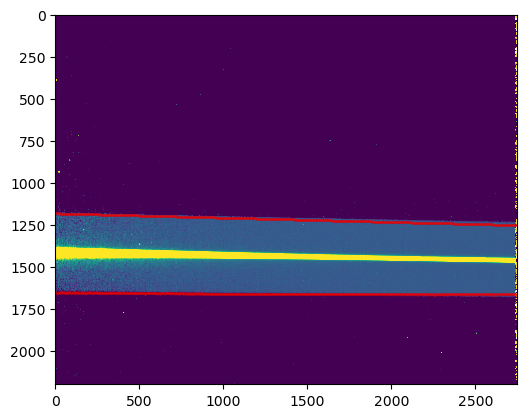

In [418]:
#plot a scatterplot with all points contained in coord
plt.imshow(IMMAG_0_flat_sky,clim=[-40,100])
plt.scatter(*zip(*sopra_conv),s=0.01,c='r')
plt.scatter(*zip(*sotto_conv),s=0.01,c='r')


In [419]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

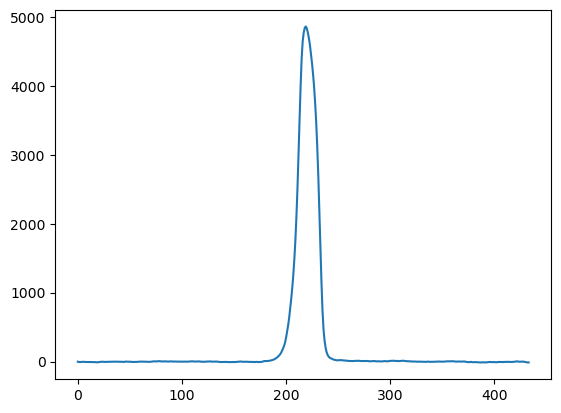

In [420]:
x_considerato=1000
plt.plot(moving_average(IMMAG_0_flat_sky[sopra_conv[x_considerato][1]:sotto_conv[x_considerato][1],x_considerato],20))

In [421]:
mean_slitta=moving_average(IMMAG_0_flat_sky[sopra_conv[x_considerato][1]:sotto_conv[x_considerato][1],x_considerato][0:100],20).mean()
std_slitta=moving_average(IMMAG_0_flat_sky[sopra_conv[x_considerato][1]:sotto_conv[x_considerato][1],x_considerato][0:100],20).std()

In [422]:
slitta=[]
for x_considerato in range(0,mean_flat.shape[1],200):
    slitta.append(moving_average(IMMAG_0_flat_sky[sopra_conv[x_considerato][1]:sotto_conv[x_considerato][1],x_considerato],20).argmax()/(sotto_conv[x_considerato][1]-sopra_conv[x_considerato][1]))
print(mean(slitta))

0.48673479023110156


In [423]:
height_stripe=(np.array(sotto_conv)[:,1]-np.array(sopra_conv)[:,1])

In [424]:
tolerance=40
stripe_center=(np.array(sopra_conv)[:,1]+height_stripe*mean(slitta)).astype(int)
stripe_cen_sopra=stripe_center-tolerance
stripe_cen_sotto=stripe_center+tolerance

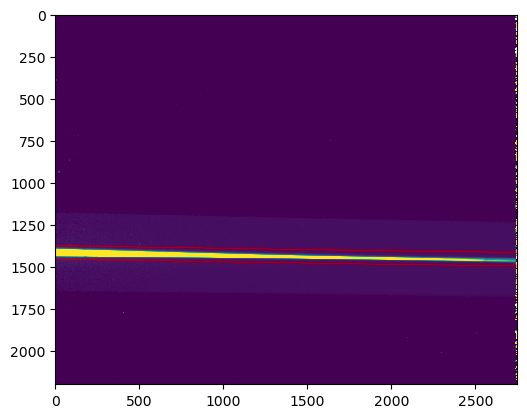

In [425]:
#plot stripe center
plt.imshow(IMMAG_0_flat_sky,clim=[-40,1000])

plt.scatter(np.array(sopra_conv)[:,0],stripe_cen_sopra,s=0.001,c='r')
plt.scatter(np.array(sopra_conv)[:,0],stripe_cen_sotto,s=0.001,c='r')

plt.savefig("IMMAG_stripe_center.png")



In [426]:
stripe_sum=[]
for x in range(IMMAG_0_flat.shape[1]):
    stripe_sum_x=[]
    span=tolerance*2
    for y in range(stripe_cen_sopra[x],stripe_cen_sotto[x]):
        stripe_sum_x.append(IMMAG_0_flat[y,x])
    stripe_sum_x=np.array(stripe_sum_x)
    stripe_sum.append((stripe_sum_x).sum())

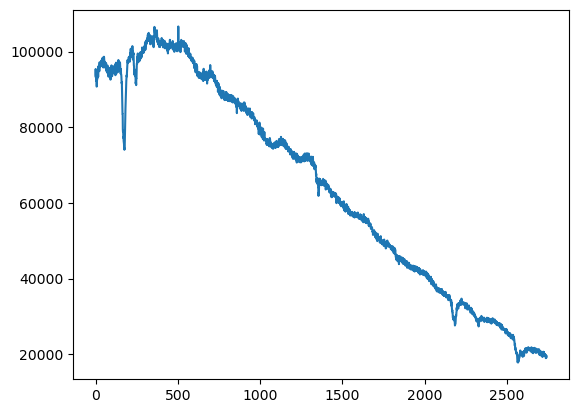

In [457]:
plt.plot((stripe_sum*mean_flat_x/flat_grand_mean)[:-9])

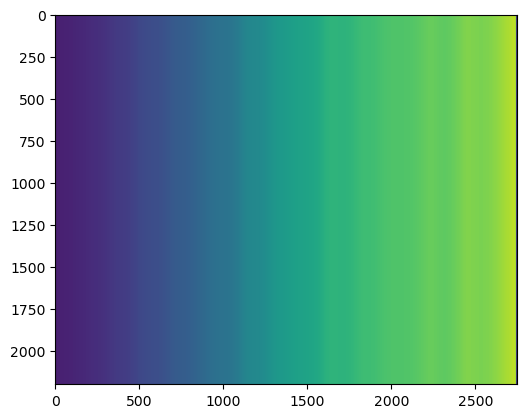

In [459]:
#plot granflat
plt.imshow(np.tile(mean_flat_x/flat_grand_mean,(2200,1)),clim=[0,2])